In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Style and format preferences

# Apply the Seaborn style
plt.style.use('seaborn-v0_8-deep')
# Disable scientific notation
pd.options.display.float_format = '{:.0f}'.format

In [29]:
# Read CSV without initial date parsing
df = pd.read_csv('master_transaksi.csv')

# List of date columns to enforce conversion with errors='coerce'
date_columns = ['order_req', 'order_sent']

# Apply pd.to_datetime with errors='coerce' to each date column
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%Y-%m-%d")

In [30]:
df.head(5)

,orderID,order_sent,custName,order_req,type,productName,sales,perprice,qty,qty_req
0,TRXINV1G1O0044,2016-01-05,A L F A - DEPOK,2016-01-05,DO,HWD-766,1HER2,1549000,5,5
1,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-P170-SL,1HER2,1641000,2,2
2,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-G256H-BK,1HER2,3226000,2,2
3,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-350,1HER2,4121000,2,2
4,TRXINV1G1O0045,2016-01-05,A L F A - DEPOK,2016-01-05,DO,HWD-773SH,1HER2,1564000,5,5


In [31]:
df['totalprice'] = df['qty'] * df['perprice']

# Aggregate monthly metrics grouped by purchase month
monthly_summary = df.groupby(df['order_req'].dt.to_period('M').rename('purchase_month')).agg(
    sales_total=('totalprice', 'sum'),
    sales_average=('totalprice', 'mean'),
    orders_total=('orderID', 'count')
)

# Calculate the growth rate for each metric
monthly_summary['sales_growth_rate'] = monthly_summary['sales_total'].pct_change() * 100
monthly_summary['aov_growth_rate'] = monthly_summary['sales_average'].pct_change() * 100
monthly_summary['order_growth_rate'] = monthly_summary['orders_total'].pct_change() * 100

# Fill NaN values with 0, round, and convert to integers
monthly_summary = monthly_summary.fillna(0).round(2)

# Apply background gradient to the growth columns with a custom colormap
styled_summary = monthly_summary.style.format("{:,}")  # Apply comma formatting
styled_summary = styled_summary.background_gradient(
    subset=['sales_growth_rate', 'aov_growth_rate', 'order_growth_rate'],
    cmap="RdYlGn",  # Red to Yellow to Green colormap
    vmin=-100,      # Set minimum for orange on the left end
    vmax=100        # Set maximum for green on the right end
)

# Display the styled DataFrame
styled_summary

,sales_total,sales_average,orders_total,sales_growth_rate,aov_growth_rate,order_growth_rate
purchase_month,,,,,,
2016-01,"614,091,700","6,674,909.78",92,0.0,0.0,0.0
2016-02,"489,111,618","7,524,794.12",65,-20.35,12.73,-29.35
2016-03,"379,413,760","6,541,616.55",58,-22.43,-13.07,-10.77
2016-04,"482,048,161","4,547,624.16",106,27.05,-30.48,82.76
2016-05,"572,918,370","5,070,074.07",113,18.85,11.49,6.6
2016-06,"1,290,943,820","7,132,286.3",181,125.33,40.67,60.18
2016-07,"718,156,105","5,886,525.45",122,-44.37,-17.47,-32.6
2016-08,"809,772,427","5,327,450.18",152,12.76,-9.5,24.59
2016-09,"924,737,321","5,890,046.63",157,14.2,10.56,3.29


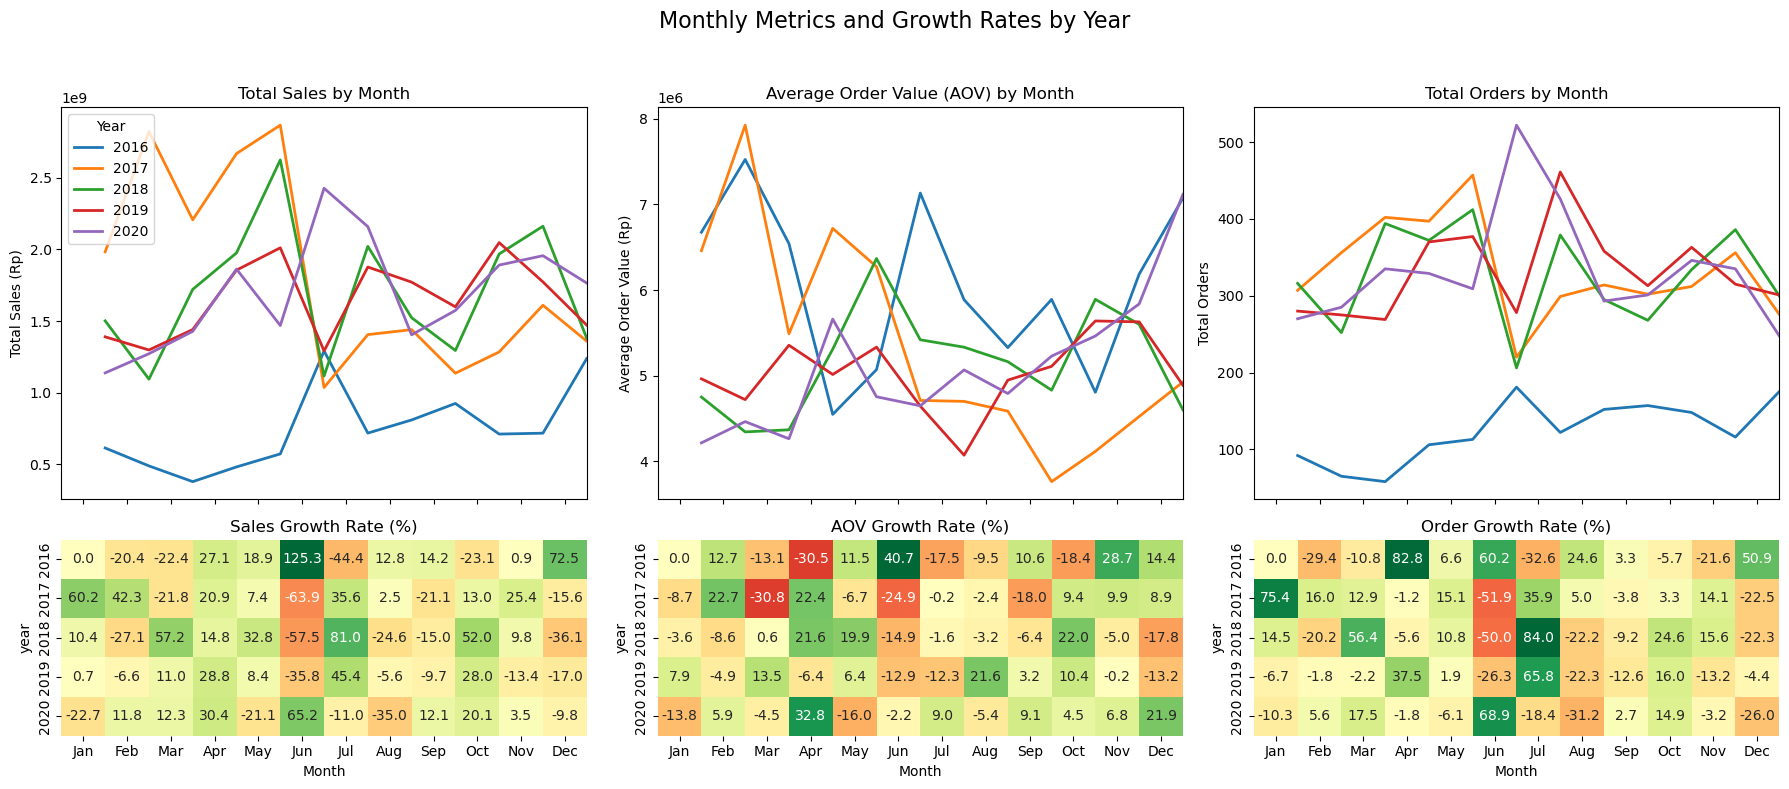

In [32]:
# Extract year and month from the date i
monthly_summary['year'] = monthly_summary.index.year
monthly_summary['month'] = monthly_summary.index.month

# Set up the figure with a 2x3 grid: 3 line charts and 3 heatmaps
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex='col', gridspec_kw={'height_ratios': [2, 1]})

# Define colors for each year
years = monthly_summary['year'].unique()
colors = plt.cm.tab10(np.arange(len(years)))  # Use tab10 colormap for consistent color assignment; current style is too dark

# Metrics to plot
metrics = ['sales_total', 'sales_average', 'orders_total']
titles = ['Total Sales by Month', 'Average Order Value (AOV) by Month', 'Total Orders by Month']
y_labels = ['Total Sales (Rp)', 'Average Order Value (Rp)', 'Total Orders']
growth_metrics = ['sales_growth_rate', 'aov_growth_rate', 'order_growth_rate']
growth_titles = ['Sales Growth Rate (%)', 'AOV Growth Rate (%)', 'Order Growth Rate (%)']

# Plot line charts for each metric
for i, (metric, title, y_label) in enumerate(zip(metrics, titles, y_labels)):
    for j, year in enumerate(years):
        yearly_data = monthly_summary[monthly_summary['year'] == year]
        axes[0, i].plot(yearly_data['month'], yearly_data[metric], label=f'{year}', color=colors[j], linewidth=2)
    axes[0, i].set_title(title)
    axes[0, i].set_ylabel(y_label)
    axes[0, i].set_xticks(range(1, 13))
    axes[0, i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    if i == 0:
        axes[0, i].legend(title='Year', loc='upper left')

# Prepare and plot heatmaps for growth rates
for i, (growth_metric, growth_title) in enumerate(zip(growth_metrics, growth_titles)):
    growth_data = monthly_summary.pivot_table(index='year', columns='month', values=growth_metric)
    sns.heatmap(growth_data, cmap='RdYlGn', ax=axes[1, i], cbar=False, annot=True, fmt=".1f", center=0)
    axes[1, i].set_title(growth_title)
    axes[1, i].set_xticks(np.arange(0.5, 12))
    axes[1, i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[1, i].set_xlabel('Month')

# Final layout adjustments
plt.suptitle('Monthly Metrics and Growth Rates by Year', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [33]:
# Aggregation for each product with inline calculations for percentages

product_performance = df.groupby('productName').agg(
    total_revenue=('totalprice', 'sum'),
    total_revenue_pct=('totalprice', lambda x: x.sum() / df['totalprice'].sum() * 100),
    aov=('totalprice', 'mean'),
    order_count=('orderID', 'count'),
    order_count_pct=('orderID', lambda x: x.count() / df['orderID'].count() * 100)
)

# Sort by Total Revenue in descending order
product_performance = product_performance.sort_values(by='total_revenue', ascending=False)

# Round values to two decimal places
product_performance = product_performance.round(2)

# Apply background gradients and comma formatting
styled_product_performance = product_performance.style.format("{:,.2f}").background_gradient(
    subset=['aov', 'total_revenue_pct', 'order_count_pct'],
    cmap="Greens",
    vmin=0
)

# Display the styled DataFrame
styled_product_performance

,total_revenue,total_revenue_pct,aov,order_count,order_count_pct
productName,,,,,
SRS-278-MR,"2,125,482,643.00",2.33,"6,480,130.01",328.00,1.89
SRS-278-BK,"2,045,752,273.00",2.24,"6,333,598.37",323.00,1.86
PESA-05DL-01,"1,937,294,272.00",2.12,"8,174,237.43",237.00,1.37
TW-8650BU,"1,785,175,505.00",1.96,"4,103,851.74",435.00,2.51
SK-V171A-SB,"1,778,541,390.00",1.95,"10,340,356.92",172.00,0.99
HWD-Z88,"1,690,871,024.00",1.85,"7,616,536.14",222.00,1.28
TW-8650MR,"1,612,937,444.00",1.77,"4,114,636.34",392.00,2.26
PSMM-3500BU1,"1,388,273,692.00",1.52,"4,837,190.56",287.00,1.65
TW-1123GX,"1,302,878,770.00",1.43,"6,647,340.66",196.00,1.13


In [34]:
# Read CSV containing all products' data
df1 = pd.read_csv('master_produk.csv')

# Drop redundant/unnecessary columns
df1 = df1.drop(columns=['qty', 'price'])

In [35]:
# Merge transaction table (master_transaksi) and product table (master_produk)
df_itemsales = pd.merge(df, df1, how='inner', on='productName')

In [38]:
df_itemsales.head(5)

,orderID,order_sent,custName,order_req,type,productName,sales,perprice,qty,qty_req,totalprice,itemID,itemType
0,TRXINV1G1O0044,2016-01-05,A L F A - DEPOK,2016-01-05,DO,HWD-766,1HER2,1549000,5,5,7745000,2,Water Dispenser
1,TRXINV1G2O0975,2016-02-27,A L F A - DEPOK,2016-02-24,DO,HWD-766,1HER2,1549000,5,5,7745000,2,Water Dispenser
2,TRXINVCH400009,2017-04-19,AGUNG JAYA,2017-04-10,DO,HWD-766,CBERT,1454000,3,3,4362000,2,Water Dispenser
3,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-P170-SL,1HER2,1641000,2,2,3282000,8,Refrigerator
4,TRXINV5G1O0042,2016-01-15,"METRO - PURBALINGGA"""" KMET01""""",2016-01-12,DO,SK-P170-SL,5YUL,1675000,10,10,16750000,8,Refrigerator


In [68]:
# Aggregation for each item type (refrigerator, washing machine, etc.) with inline calculations for percentages

product_performance = df_itemsales.groupby('itemType').agg(
    total_revenue=('totalprice', 'sum'),
    total_revenue_pct=('totalprice', lambda x: x.sum() / df_itemsales['totalprice'].sum() * 100),
    aov=('totalprice', 'mean'),
    order_count=('orderID', 'count'),
    order_count_pct=('orderID', lambda x: x.count() / df_itemsales['orderID'].count() * 100)
)

# Sort by Total Revenue in descending order
product_performance = product_performance.sort_values(by='total_revenue', ascending=False)

# Round values to two decimal places
product_performance = product_performance.round(2)

# Apply background gradients and comma formatting
styled_product_performance = product_performance.style.format("{:,.2f}").background_gradient(
    subset=['aov', 'total_revenue_pct', 'order_count_pct'],
    cmap="Greens", 
    vmin=0
)

# Display the styled DataFrame
styled_product_performance

,total_revenue,total_revenue_pct,aov,order_count,order_count_pct
itemType,,,,,
Refrigerator,"38,487,328,025.00",42.15,"6,257,084.71","6,151.00",35.44
Washing Machine,"27,151,595,485.00",29.74,"5,562,711.63","4,881.00",28.12
Water Dispenser,"9,321,859,042.00",10.21,"4,865,270.90","1,916.00",11.04
Rice Cooker,"5,354,192,175.00",5.86,"2,851,007.55","1,878.00",10.82
Microphone,"2,927,634,454.00",3.21,"8,585,438.28",341.00,1.96
Speaker,"2,690,828,868.00",2.95,"4,591,858.14",586.00,3.38
TV,"1,614,998,072.00",1.77,"6,459,992.29",250.00,1.44
Gas Stove,"1,540,148,742.00",1.69,"3,086,470.42",499.00,2.88
AC,"1,157,375,072.00",1.27,"4,538,725.77",255.00,1.47


In [7]:
df.head(5)

,orderID,order_sent,custName,order_req,type,productName,sales,perprice,qty,qty_req
0,TRXINV1G1O0044,2016-01-05,A L F A - DEPOK,2016-01-05,DO,HWD-766,1HER2,1549000,5,5
1,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-P170-SL,1HER2,1641000,2,2
2,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-G256H-BK,1HER2,3226000,2,2
3,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-350,1HER2,4121000,2,2
4,TRXINV1G1O0045,2016-01-05,A L F A - DEPOK,2016-01-05,DO,HWD-773SH,1HER2,1564000,5,5


In [69]:
# Extract the year from the 'order_req' column and assign it to a new column 'purchase_year'
df['purchase_year'] = pd.to_datetime(df['order_req']).dt.year

# Group by customer_id and purchase_year, and calculate order_count
customer_orders = (
    df.groupby(['custName', 'purchase_year'])
    .size()
    .reset_index(name='order_count')
)

# Group by purchase_year to calculate unique_customers and repeat_customers
summary = (
    customer_orders.groupby('purchase_year')
    .agg(
        unique_customers=('custName', 'nunique'),
        repeat_customers=('order_count', lambda x: (x >= 2).sum())
    )
    .reset_index()
)

# Calculate repeat_rate
summary['repeat_rate'] = (summary['repeat_customers'] / summary['unique_customers'] * 100).round(2)

# Display the summary sorted by purchase_year
summary = summary.sort_values('purchase_year')

styled_summary = summary.style.format("{:,.2f}", subset=['repeat_rate']).set_table_styles(
    [{
        'selector': 'table',
        'props': [('border', '1px solid black'), ('border-collapse', 'collapse')]
    }, {
        'selector': 'th, td',
        'props': [('border', '1px solid black'), ('padding', '8px')]
    }]
)

# Display the styled table
styled_summary


,purchase_year,unique_customers,repeat_customers,repeat_rate
0,2016,46,43,93.48
1,2017,108,90,83.33
2,2018,120,94,78.33
3,2019,116,104,89.66
4,2020,90,79,87.78


In [70]:
# Read customer data
df2 = pd.read_csv('master_customer.csv')

# Merge transaction data (master_transaksi) and customer's data (master_customer)
df_areasales = pd.merge(df, df2, how='inner', on='custName')

In [40]:
df_areasales.head(5)

,orderID,order_sent,custName,order_req,type,productName,sales,perprice,qty,qty_req,purchase_year,customer_id,address,province
0,TRXINV1G1O0044,2016-01-05,A L F A - DEPOK,2016-01-05,DO,HWD-766,1HER2,1549000,5,5,2016,1,JL.PSR KEBAYORAN LAMA NO. 19 KEBAYORAN LAMA,DKI Jakarta
1,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-P170-SL,1HER2,1641000,2,2,2016,1,JL.PSR KEBAYORAN LAMA NO. 19 KEBAYORAN LAMA,DKI Jakarta
2,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-G256H-BK,1HER2,3226000,2,2,2016,1,JL.PSR KEBAYORAN LAMA NO. 19 KEBAYORAN LAMA,DKI Jakarta
3,TRXINV1G1O0046,2016-01-05,A L F A - DEPOK,2016-01-05,DO,SK-350,1HER2,4121000,2,2,2016,1,JL.PSR KEBAYORAN LAMA NO. 19 KEBAYORAN LAMA,DKI Jakarta
4,TRXINV1G1O0045,2016-01-05,A L F A - DEPOK,2016-01-05,DO,HWD-773SH,1HER2,1564000,5,5,2016,1,JL.PSR KEBAYORAN LAMA NO. 19 KEBAYORAN LAMA,DKI Jakarta


In [65]:
# Calculate totalprice for df_areasales
df_areasales['totalprice'] = df['qty'] * df['perprice']

# Annual summary grouped by province and year
yearly_region_summary = df_areasales.groupby(
    ['province', df_areasales['order_req'].dt.to_period('Y').rename('purchase_year')]
).agg(
    total_sales=('totalprice', 'sum'),
    avg_sales=('totalprice', 'mean'),
    total_orders=('orderID', 'count')
)

# Identify the top 5 provinces based on total sales
top_provinces = (
    yearly_region_summary.groupby('province')['total_sales']
    .sum()
    .nlargest(5)
    .index
)

# Filter for only the top 5 provinces
yearly_region_summary = yearly_region_summary.loc[yearly_region_summary.index.get_level_values('province').isin(top_provinces)]

# Calculate the growth rate for each metric within each region
yearly_region_summary['sales_growth_rate'] = yearly_region_summary.groupby('province')['total_sales'].pct_change() * 100
yearly_region_summary['aov_growth_rate'] = yearly_region_summary.groupby('province')['avg_sales'].pct_change() * 100
yearly_region_summary['order_growth_rate'] = yearly_region_summary.groupby('province')['total_orders'].pct_change() * 100

# Fill NaN values with 0 and round to 0 decimals
yearly_region_summary = yearly_region_summary.fillna(0).round(0)

# Apply background gradient and comma formatting
styled_yearly_region_summary = yearly_region_summary.style.format("{:,}").background_gradient(
    subset=['sales_growth_rate', 'aov_growth_rate', 'order_growth_rate'],
    cmap="RdYlGn",
    vmin=-100,
    vmax=100
)

# Display the styled yearly region summary
styled_yearly_region_summary

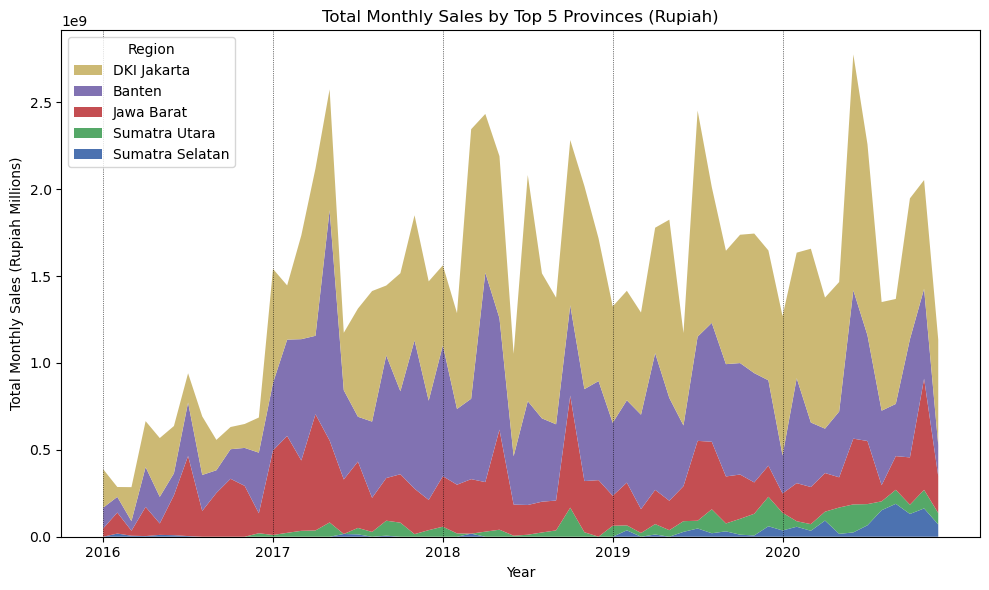

In [67]:
# Group by 'region' and 'month' to calculate monthly total sales
monthly_sales = df_areasales.groupby(
    [df_areasales['order_req'].dt.to_period('M'), 'province']
)['totalprice'].sum().unstack(fill_value=0)

# Identify the top 5 regions based on total sales
top_regions = monthly_sales.sum(axis=0).nlargest(5).index

# Filter the data to include only the top 5 regions
monthly_sales_top = monthly_sales[top_regions]

# Sort the columns (regions) by total sales in descending order for proper stacking
monthly_sales_top = monthly_sales_top[top_regions[::-1]]

# Normalize to get the percentage contribution of each region per month
monthly_sales_percent_top = monthly_sales_top.div(monthly_sales_top.sum(axis=1), axis=0) * 100

# Define a function to plot stacked area charts with yearly markers and yearly x-axis labels
def plot_stacked_area(data, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.stackplot(data.index.astype(str), data.T, labels=data.columns)

    # Add vertical lines at the start of each year
    years = sorted(data.index.year.unique())
    for year in years:
        plt.axvline(x=f'{year}-01', color='black', linestyle=':', linewidth=0.5)

    # Reverse legend order to match stacking
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc='upper left', title='Region')

    # Set titles and labels
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)

    # Show only years on the x-axis labels
    plt.xticks([f"{year}-01" for year in years], [str(year) for year in years])

    plt.tight_layout()
    plt.show()

# Plot the total sales stacked area chart for the top 5 regions
plot_stacked_area(
    monthly_sales_top,
    title='Total Monthly Sales by Top 5 Provinces (Rupiah)',
    ylabel='Total Monthly Sales (Rupiah Millions)'
)